Initializing Packages

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import os
import re

Section 1: Loading in the data and storing it as lists

In [191]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

In [ ]:
directory = "team_battery"

# Regex to capture the float X from filenames like cal_10_(X).mca
pattern = re.compile(r"ba_\d+\_(\d*)\.mca")

# Temporary storage for (x_value, data_list)
temp_storage = []

for filename in os.listdir(directory):
    match = pattern.search(filename)
    if match:
        x_value = float(match.group(1))
        file_path = os.path.join(directory, filename)
        data = extract_mca_data(file_path)
        temp_storage.append((x_value, data))

# Sort by x_value
temp_storage.sort(key=lambda item: item[0])

# Separate into two lists 
file_labels = [item[0] for item in temp_storage]
all_data_lists = [item[1] for item in temp_storage]

print(f"Loaded {len(all_data_lists)} files in ascending order of X.")
for i, data_list in enumerate(all_data_lists):
    print(f"File {i+1} (X={file_labels[i]}): {len(data_list)} points")
    
# The data is stored in acdending order of bias voltage in the all_data_lists and file lables are the bias voltages

Loaded 24 files in ascending order of X.
File 1 (X=1157.0): 1024 points
File 2 (X=1207.0): 1024 points
File 3 (X=1258.0): 1024 points
File 4 (X=1309.0): 1024 points
File 5 (X=1309.0): 1024 points
File 6 (X=1359.0): 1024 points
File 7 (X=1410.0): 1024 points
File 8 (X=1459.0): 1024 points
File 9 (X=1459.0): 1024 points
File 10 (X=1509.0): 1024 points
File 11 (X=1559.0): 1024 points
File 12 (X=1559.0): 1024 points
File 13 (X=1610.0): 1024 points
File 14 (X=1659.0): 1024 points
File 15 (X=1659.0): 1024 points
File 16 (X=1709.0): 1024 points
File 17 (X=1760.0): 1024 points
File 18 (X=1760.0): 1024 points
File 19 (X=1809.0): 1024 points
File 20 (X=1859.0): 1024 points
File 21 (X=1910.0): 1024 points
File 22 (X=1960.0): 1024 points
File 23 (X=2010.0): 1024 points
File 24 (X=2121.0): 1024 points


In [ ]:
bkg=extract_mca_data('team_battery/bkg_10_1789.mca')
# Initialising the background

In [ ]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))
#defining the gaussian

Creating functions to run withing loops (The names are self explainatory)

In [ ]:
def bkg_corrector(bkg_list,data_list,index):
    bkg_corr_data_list=[]
    for i in range(0,len(bkg_list)):
        bkg_corr_data=data_list[index][i]-bkg_list[i]
        bkg_corr_data_list.append(bkg_corr_data)
    bkg_corr_data_list=np.array(bkg_corr_data_list).clip(min=0)
    return bkg_corr_data_list

In [196]:
def curve_fit(function, channel, data_list,range,init_guess):
    mu, cov=sci.curve_fit(function,channel[range[0]:range[1]],data_list[index][range[0]:range[1]],p0=init_guess)
    gauss=gaussian(channel,*mu)
    return gauss

Test section to fit and run per voltage fits

In [ ]:
index=22
h=20
t=10
peak_pnts=[]
range_list=[60,98]
init_guess=[350,70,1]

import seaborn as sns
import scipy.signal as fp
peak_loc,peak_heights=fp.find_peaks(x=all_data_lists[index],height=h,threshold=t)
print(peak_loc)

for i in peak_loc:
    peak_ind=all_data_lists[index][i]
    peak_pnts.append(peak_ind)

#plotting the curve and the peaks (Still working on the automatic fitting, worst case scenario we can just manually fit the curves)
bkg_corr_ind=bkg_corrector(bkg,all_data_lists,index)
channel_no=np.linspace(0,len(all_data_lists[index]),1024)
fig, ax = plt.subplots()
ax.plot(channel_no,all_data_lists[index],label=file_labels[index])
ax.plot(channel_no,bkg,label='background')
ax.plot(channel_no,bkg_corr_ind,label='background corrected')
ax.plot(peak_loc,peak_pnts,'b.')
ax.legend()
# plt.xlim(0,300)
plt.show()
print(all_data_lists[index])
print(bkg)


[ 33  42 101 132 179 192 194 227 252 257 259 269 272 286 288 291 293 301
 303 306 314 321]


Final Histogram plotting

In [199]:
numline=len(all_data_lists)
colour=plt.cm.plasma(np.linspace(0,1,numline))

In [200]:
def hist_generator_bkg_corrected(index,data_list,bkg,label_list,color):
    bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    plt.plot(np.linspace(0,len(data_list[index]),1024),bkg_correction,label=f"corrected {label_list[index]}",color=color)
    plt.xlim(0,100)
    plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))


In [201]:
def hist_generator(index,data_list,bkg,label_list,color):
    # bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    plt.plot(np.linspace(0,len(data_list[index]),1024),all_data_lists[index],label=f"{label_list[index]}",color=color)
    plt.xlim(0,100)
    plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))


The line at 200 is just an arbitrary level I used to check if my background deletion is working

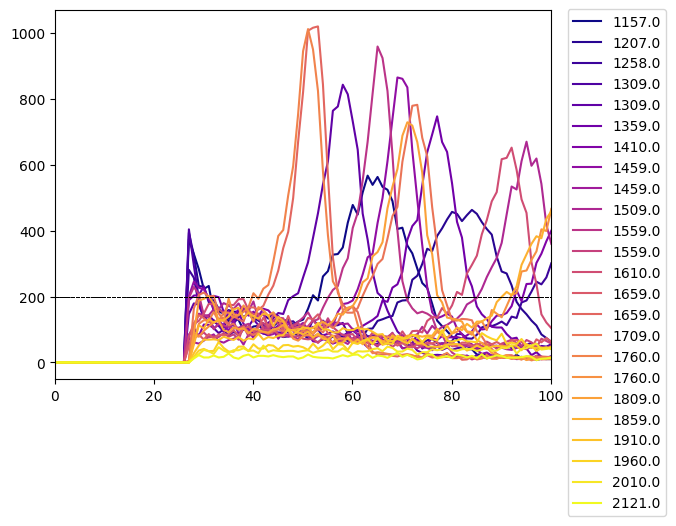

In [202]:
for i in range(0,len(all_data_lists)):
    hist_generator(i,all_data_lists,bkg,file_labels,colour[i])
    

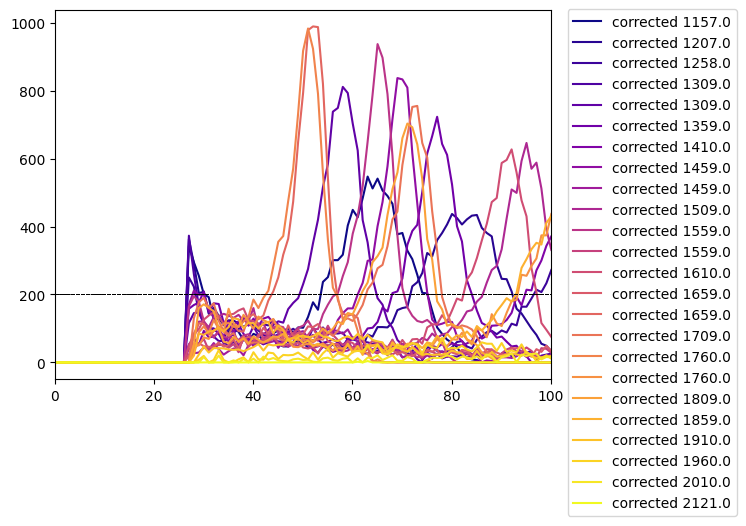

In [203]:
for i in range(0,len(all_data_lists)):
    hist_generator_bkg_corrected(i,all_data_lists,bkg,file_labels,colour[i])
    